In [1]:
# Import libraries
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

In [2]:
# Seeds
torch.manual_seed(123456)
np.random.seed(123456)
device = torch.device('cpu')

In [3]:
# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(1, 30))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 7):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_FVM(self, x,q,nx):
        y = self.net(x)
        q_1 = torch.tensor(q[0,1:nx-1].flatten()[:, None],dtype=torch.float32).to(device)
        q_2 = torch.tensor(q[1,1:nx-1].flatten()[:, None], dtype=torch.float32).to(device)
        q_3 = torch.tensor(q[2,1:nx-1].flatten()[:, None], dtype=torch.float32).to(device)
        f = (((y[:,0:1] - q_1))**2).mean() + (((y[:,1:2] - q_2))**2).mean() + (((y[:,2:] - q_3))**2).mean()
        return f


In [4]:
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)


In [5]:
# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))


In [6]:
def Euler_IC1d(x, case):
    if case == 1:
        p = [1, 0.1]
        u = [0, 0]
        rho = [1, 0.125]

    r0 = np.zeros(len(x))
    u0 = np.zeros(len(x))
    p0 = np.zeros(len(x))

    x_middle = (x[-1] - x[0]) / 2

    L = np.where(x <= x_middle)
    R = np.where(x >= x_middle)

    r0[L], r0[R] = rho[0], rho[1]
    u0[L], u0[R] = u[0], u[1]
    p0[L], p0[R] = p[0], p[1]

    return r0, u0, p0



In [7]:
def minmod(v):
    s = np.sum(np.sign(v)) / np.size(v)
    if abs(s) == 1:
        mm = s * np.min(np.abs(v[:]))
    else:
        mm = 0
    return mm

In [8]:
def HLLEflux(qL, qR, gamma):
    rL = qL[0]
    uL = qL[1] / rL
    EL = qL[2] / rL
    pL = (gamma - 1) * (qL[2] - rL * uL * uL / 2)

    aL = np.sqrt(gamma * pL / rL)
    HL = (qL[2] + pL) / rL

    rR = qR[0]
    uR = qR[1] / rR
    ER = qR[2] / rR
    pR = (gamma - 1) * (qR[2] - rR * uR * uR / 2)

    aR = np.sqrt(gamma * pR / rR)
    HR = (qR[2] + pR) / rR

    RT = np.sqrt(rR / rL)
    u = (uL + RT * uR) / (1 + RT)
    H = (HL + RT * HR) / (1 + RT)
    a = np.sqrt((gamma - 1) * (H - u * u / 2))

    SLm = np.min([uL - aL, u - a])
    SRp = np.max([uR + aR, u + a])

    FL = np.zeros((3, 1))
    FR = np.zeros((3, 1))
    FL[0], FL[1], FL[2] = rL * uL, rL * uL ** 2 + pL, uL * (rL * EL + pL)
    FR[0], FR[1], FR[2] = rR * uR, rR * uR ** 2 + pR, uR * (rR * ER + pR)

    if SLm >= 0:
        HLLE = FL

    elif (SLm <= 0) and (SRp >= 0):
        HLLE = (SRp * FL - SLm * FR + SLm * SRp * (qR - qL)) / (SRp - SLm)

    elif SRp <= 0:
        HLLE = FR

    return HLLE


In [9]:
def MUSCL_EulerRes1d(q, smax, gamma, dx, N):
    # Compute and limit slopes
    res = np.zeros((3, N))
    dq = np.zeros((3, N))
    flux = np.zeros((3, N - 1))
    q_l = np.zeros((3, N - 1))
    q_r = np.zeros((3, N - 1))
    for i in range(0, 3):
        for j in range(1, N - 1):
            dqR = 2 * (q[i, j + 1] - q[i, j])
            dqL = 2 * (q[i, j] - q[i, j - 1])
            dqC = (q[i, j + 1] - q[i, j - 1]) / 2
            dq[i, j] = minmod(np.array([dqR, dqL, dqC]))

    for j in range(1, N - 2):
        q_l[:, [j]] = q[:, [j]] + dq[:, [j]] / 2
        q_r[:, [j]] = q[:, [j + 1]] - dq[:, [j + 1]] / 2
    for j in range(1, N - 2):
        flux[:, [j]] = HLLEflux(q_l[:, [j]], q_r[:, [j]], gamma)
        res[:, [j]] = res[:, [j]] + flux[:,[j]]/dx
        res[:,[j+1]] = res[:,[j+1]] - flux[:,[j]]/dx

    q_r[:, [0]] = q[:, [1]] - dq[:, [1]] * dx / 2
    q_l[:, [0]] = q_r[:, [0]]
    flux[:, [0]] = HLLEflux(q_l[:, [0]], q_r[:, [0]], gamma)
    res[:, 1] = res[:, 1] - flux[:, 0] / dx

    q_l[:, [N - 2]] = q[:, [N - 2]] + dq[:, [N - 2]] *(dx / 2)
    q_r[:, [N - 2]] = q_l[:, [N - 2]]
    flux[:, [N - 2]] = HLLEflux(q_l[:, [N - 2]], q_r[:, [N - 2]], gamma)
    res[:, [N - 2]] = res[:, [N - 2]] + flux[:, [N - 2]] / dx
    return res

In [ ]:

# Initialization
lr = 0.0005                                                        # Learning rate
nx = 400                                                           # Number of discrete spatial points
cfl = 0.5                                                          # CFL condition for stability
tEnd = 0.15                                                        # Final time
n = 5                                                              # Number of degrees of freedom
IC = 1                                                             # Initial condition
Lx = 1                                                             # Right boundary

gamma = (n + 2) / n                                                # Heat capacity ratio
dx = Lx / nx                                                       # Spatial step
xc = np.arange(dx / 2, Lx, dx)                                     # Spatial grid

r0, u0, p0 = Euler_IC1d(xc, IC)                                    # Initial Condition
E0 = p0 / ((gamma - 1) * r0) + 0.5 * u0 ** 2                       # Initial total energy
a0 = np.sqrt(gamma * p0 / r0)                                      # Initial wave sqeed

nx += 2
q0 = np.vstack((r0, r0 * u0, r0 * E0))
zero = np.vstack((0, 0, 0))
q0 = np.hstack((zero, q0, zero))
q0[:, [0]] = q0[:, [1]]
q0[:, [nx - 1]] = q0[:, [nx - 2]]

lambda0 = np.abs(u0) + a0
dt0 = cfl * dx / np.max(lambda0)

X = xc.flatten()[:, None]                                          # Vectorized spatial domain
x_int_train = X                                                    # Training domain
x_test = X                                                         # Reevaluation domain
x_int_train = torch.tensor(x_int_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

# Initialize neural network
q = q0
t = 0
it = 0
dt = dt0
lambdas = lambda0

while (t < tEnd):
        qs = q[:, :] - dt * MUSCL_EulerRes1d(q[:, :], np.max(lambdas), gamma, dx, nx)
        qs[:, [0]] = qs[:, [1]]
        qs[:, [nx - 1]] = qs[:, [nx - 2]]

        qnew = (q[:, :] + qs[:, :] - dt * MUSCL_EulerRes1d(qs[:, :], np.max(lambdas), gamma, dx, nx)) / 2
        qnew[:, [0]] = qnew[:, [1]]
        qnew[:, [nx - 1]] = qnew[:, [nx - 2]]
        r = qnew[[0], :]
        u = qnew[[1], :] / r
        E = qnew[[2], :] / r
        p = (gamma - 1) * r * (E - 0.5 * u ** 2)
        a = np.sqrt(gamma * p / r)
        lambdas = np.abs(u) + a
        dt = cfl * dx / np.max(lambdas)
        if t + dt > tEnd:
            dt = tEnd - t
        t = t + dt
        it = it + 1
        print(it)
        model = DNN().to(device)
        # Loss and optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        # Train PINNs
        def train(epoch):
            model.train()
            def closure():
                optimizer.zero_grad()
                loss_FVM = model.loss_FVM(x_int_train, qnew, nx)
                loss = loss_FVM
                # Print iteration, loss of PDE and ICs
                #print(f'epoch {epoch} loss_pde:{loss_FVM:.8f}')
                loss.backward()
                return loss

            # Optimize loss function
            loss = optimizer.step(closure)
            loss_value = loss.item() if not isinstance(loss, float) else loss
            # Print total loss
            #print(f'epoch {epoch}: loss {loss_value:.6f}')
            return loss_value
        print('Start training...')
        tic = time.time()
        loss_value = np.inf
        epoch = 0
        while loss_value > 0.00000001:
            loss_value = train(epoch)
            epoch += 1
        toc = time.time()
        #print(f'Total training time: {toc - tic}')

        q_nn = to_numpy(model(x_test))
        q_nn = q_nn.transpose()
        q = np.zeros((3, nx))
        q[:, 1:nx - 1] = q_nn
        q[:, [0]] = q[:, [1]]
        q[:, [nx - 1]] = q[:, [nx - 2]]
scipy.io.savemat('Sod_Shock_Tube.mat', {'x': xc, 'rho': q[0, 1:nx-1],
                                            'u': q[1, 1:nx-1] / q[0, 1:nx-1],
                                            'E': q[2, 1:nx-1]/q[0, 1:nx-1]})



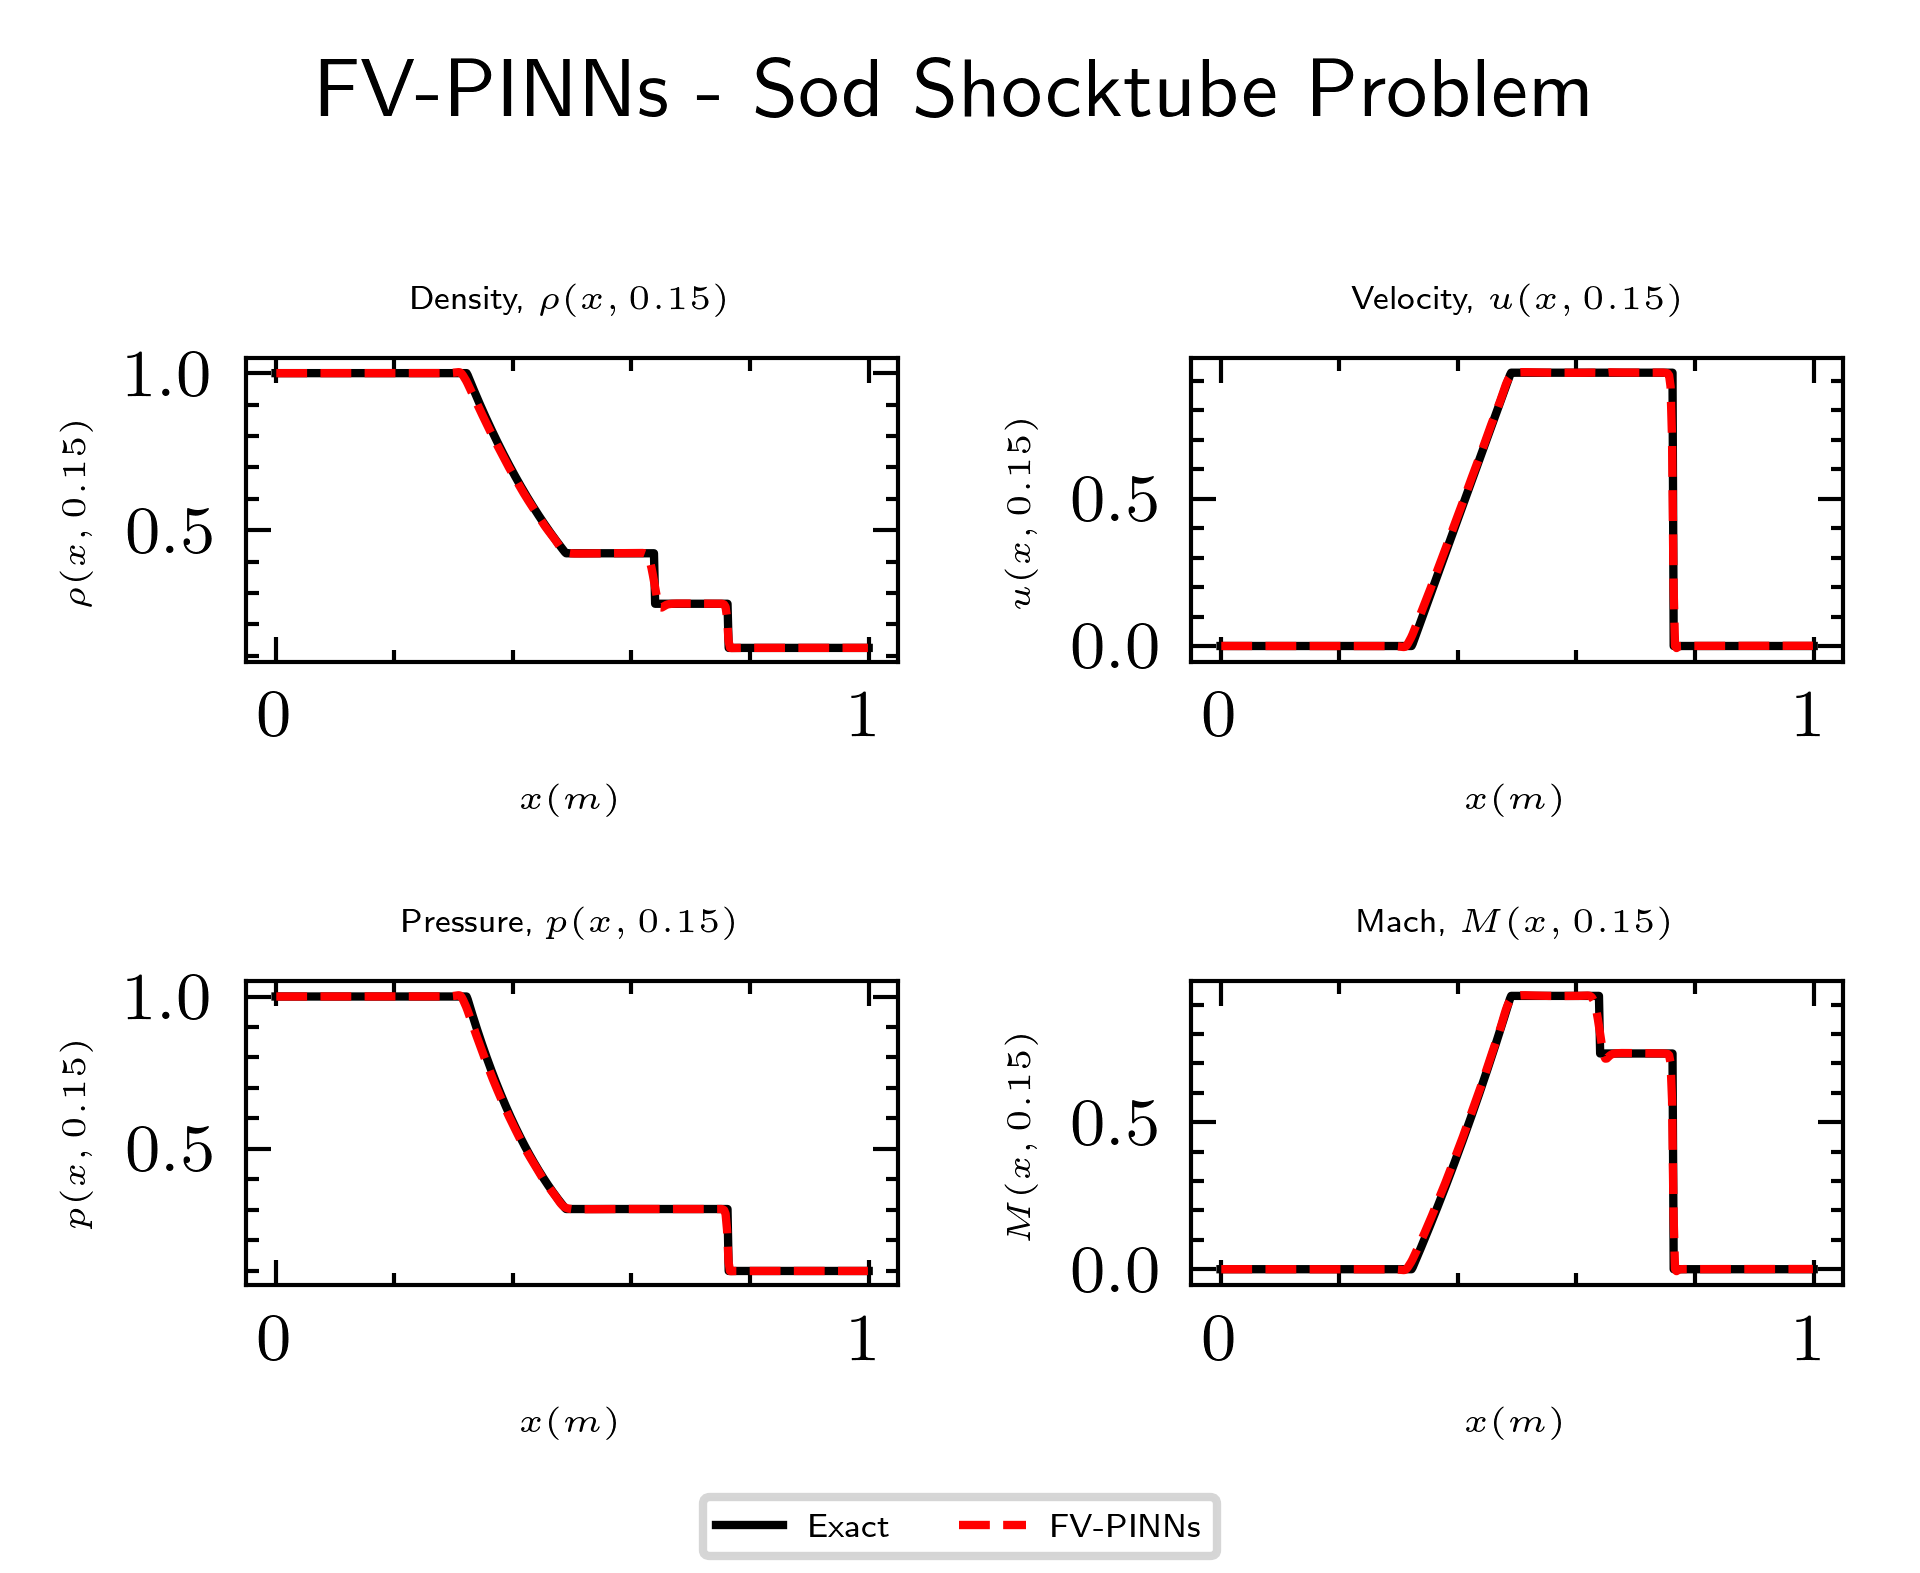

In [163]:
data = scipy.io.loadmat('Sod_Shock_Tube.mat')                                 # Import Solution data

xc   = data['x'].flatten()[:,None]                                            
rho = data['rho'].flatten()[:,None]
u   = data['u'].flatten()[:,None]
e   = data['E'].flatten()[:,None]
E   = data['E'].flatten()[:,None]*rho
pp  = (1.4-1)*rho*(e-0.5*u**2)
M = u/np.sqrt(1.4*pp/rho);

data = scipy.io.loadmat('sod_exact.mat') 
xe = data['xe'].flatten()[:,None]
re = data['re'].flatten()[:,None]
ue   = data['ue'].flatten()[:,None]
Ee  = data['Ee'].flatten()[:,None]
pe  = data['pe'].flatten()[:,None]
Me = ue/np.sqrt(1.4*pe/re);
with plt.style.context(['science','ieee']):
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
    for p in [10]:
       
        ax1.plot(xe, re, label = p)
        ax1.plot(xc, rho, label = p)
            
        ax2.plot(xe, ue, label = p)
        ax2.plot(xc, u)
            
            
        ax3.plot(xe, pe, label = p)
        ax3.plot(xc, pp, label = p)
            
        ax4.plot(xe, Me, label = p)
        ax4.plot(xc, M, label = p)
        
        ax1.set_xlabel(r'$x(m)$',fontsize = 4)
        ax1.set_ylabel(r'$\rho(x,0.15)$',fontsize = 4)
        ax1.set_title(r'Density, $\rho(x,0.15)$',fontsize = 4)
        
        ax2.set_xlabel(r'$x(m)$',fontsize = 4)
        ax2.set_ylabel(r'$u(x,0.15)$',fontsize = 4)
        ax2.set_title(r'Velocity, $u(x,0.15)$',fontsize = 4)
        
        ax3.set_xlabel(r'$x(m)$',fontsize = 4)
        ax3.set_ylabel(r'$p(x,0.15)$',fontsize = 4)
        ax3.set_title(r'Pressure, $p(x,0.15)$',fontsize = 4)
        
        ax4.set_xlabel(r'$x(m)$',fontsize = 4)
        ax4.set_ylabel(r'$M(x,0.15)$',fontsize= 4)
        ax4.set_title(r'Mach, $M(x,0.15)$',fontsize = 4)

fig.legend(['Exact', 'FV-PINNs'], ncol = 2, loc='lower center', fontsize= 4)
csfont = {'fontname':'serif'}
plt.suptitle(r'FV-PINNs - Sod Shocktube Problem', fontsize= 10, **csfont)
plt.tight_layout()
plt.show()
